<a href="https://colab.research.google.com/github/praths007/tensorflow_certification/blob/master/coursera_practise/TS_week2_simple_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.3.0'

In [39]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

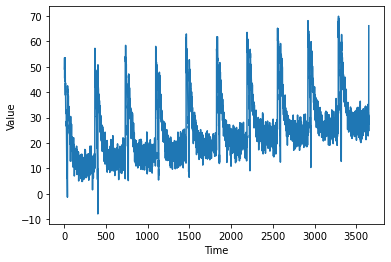

In [57]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [58]:
dataset = tf.data.Dataset.from_tensor_slices(series)

In [59]:
# for item in dataset:
#   print(item)

In [60]:
dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

In [61]:
# for item in dataset:
#   print(item)

In [62]:
dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

In [63]:
# for item in dataset:
#   print(item)

In [64]:
dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))

In [65]:
for item in dataset:
  print(item)

Streaming output truncated to the last 5000 lines.
(<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([22.520508, 16.798386, 16.947819, 23.376152, 24.908564, 18.220718,
       19.04233 , 19.383354, 18.055096, 23.038036, 18.223919, 19.447115,
       18.650375, 15.084642, 19.647583, 24.723045, 21.465977, 21.177174,
       20.105759, 23.501966], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=19.662024>)
(<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([54.975876, 52.44696 , 47.22722 , 49.959118, 47.452766, 48.40129 ,
       54.415146, 47.34042 , 51.181217, 46.21621 , 45.994724, 46.2556  ,
       53.28471 , 50.48019 , 45.206757, 42.6408  , 38.52215 , 42.173637,
       50.051052, 49.405014], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=41.312805>)
(<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([29.189438, 24.926765, 25.496912, 31.060966, 32.421234, 27.11448 ,
       26.95392 , 26.960537, 26.16444 , 31.669832, 24.739456, 34.340855,
       31.751873,

In [66]:
dataset = dataset.batch(batch_size=batch_size).prefetch(1)

In [67]:
for item in dataset:
  print(item)

Streaming output truncated to the last 5000 lines.
        23.877981  , 26.637526  , 24.682775  , 26.675253  , 22.269749  ,
        23.512224  , 19.107922  , 24.08361   , 22.571575  , 20.882153  ,
        20.262564  , 28.433884  , 22.836786  , 29.533272  , 25.812172  ],
       [32.00963   , 35.03752   , 31.885233  , 41.137856  , 35.083748  ,
        35.496426  , 35.086918  , 31.284931  , 31.222286  , 32.232964  ,
        30.870705  , 34.458748  , 34.685246  , 31.062582  , 32.88456   ,
        32.67505   , 32.516037  , 33.94641   , 32.228256  , 25.309061  ],
       [35.26395   , 34.126442  , 33.68078   , 37.497753  , 31.479067  ,
        31.850954  , 33.43361   , 33.0332    , 29.401924  , 33.430344  ,
        31.650951  , 33.84852   , 27.70454   , 29.914425  , 25.343985  ,
        26.426472  , 32.63438   , 24.9795    , 21.738844  , 32.789055  ],
       [30.962532  , 33.120457  , 32.717484  , 30.099346  , 35.653893  ,
        33.463     , 30.117722  , 31.648277  , 37.78156   , 35.878677 

In [68]:
# tf.shape(dataset)

In [69]:
l0 = Dense(1, input_shape=[window_size])
model = Sequential([
                    l0
])

In [79]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss='mse', metrics=['mse'])

history = model.fit(dataset, epochs=100, verbose=0)

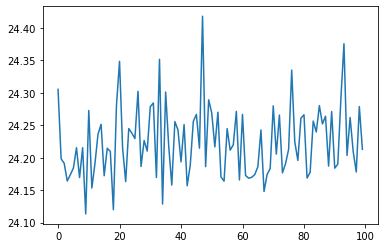

In [80]:
plt.plot(history.history['loss'])

In [81]:
series

array([49.12849 , 50.28806 , 53.549213, ..., 30.218498, 24.751186,
       66.11884 ], dtype=float32)

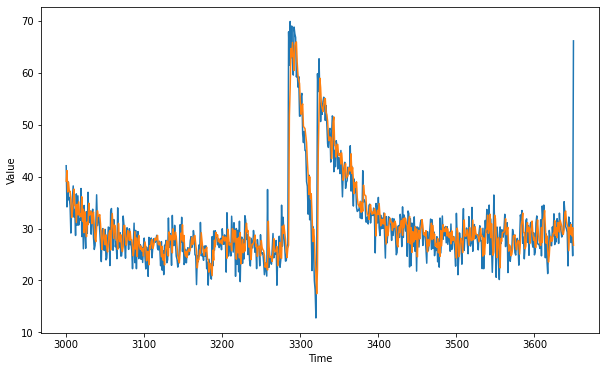

In [82]:

forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)